# План домашних заданий


- Описание задачи и знакомство с данными
- Домашнее задание 1. Генерация и фильтрация признаков
- Домашнее задание 2. Прогноз времени и вида поломки машин, настройка ML-модели
- Дополнительное задание. Визуализация прогнозов, ошибок модели и важности признаков
- Домашнее задание 3. Оптимизация. Тюнинг гиперпараметров с помощью `Optuna`
- Домашнее задание 4. Блендинг
- Домашнее задание 5. Парсинг внешних данных и оптимизация памяти
- Отправка финального решения на лидерборд на Kaggle

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# <center id="part0"> Описание задачи

**Предыстория:**  мы работаем с каршеринговой компанией, которая управляет крупным автопарком машин. Наша цель — предотвратить длительные периоды простоя машин из-за поломок через своевременное обслуживание и ремонт.


**Идея для решения проблемы:** создать приоритизированный список обхода машин. Этот список поможет технической бригаде сосредоточиться на автомобилях, которые наиболее вероятно выйдут из строя в ближайшее время.


**Как компания решает задачу:**

* Собирает данные о поездках и состоянии машин до поломок.

* Нанимает Data Scientist, чтобы он смог использовать эти данные для анализа и прогнозирования характера поломок.

**Важный момент**: задачи этого специалиста (Data Scientist) предстоит выполнять вам.

## <center> Знакомство с данными

### Информация про машины с таргетом (основной датасет)

In [2]:
car_train = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/car_train.csv')
car_train.sample(5)

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class
1635,L85244434f,Renault Kaptur,standart,petrol,3.04,2012,21873,2018,37.42,engine_overheat
2245,w33168720l,VW Tiguan,economy,petrol,3.66,2015,94430,2017,58.34,engine_check
1393,X88728094G,Renault Sandero,standart,petrol,3.90,2015,75874,2020,28.52,engine_overheat
756,k14397227n,Hyundai Solaris,economy,petrol,1.60,2012,28604,2020,30.24,wheel_shake
769,y10620904U,Kia Sportage,standart,petrol,3.24,2013,40935,2014,31.65,electro_bug


- `car_id` — идентификатор машины
- `model` / `car_type` / `fuel_type` — марка, класс и тип топлива машины
- `car_rating` / `riders` — общий рейтинг и общее число поездок к концу 2021 года
- `year_to_start` / `year_to_work` — год выпуска машины и год начала работы в автопарке
- `target_reg` — количество дней до поломки
- `target_class` — класс поломки (всего 9 видов)

### Информация про поездки

In [3]:
rides_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/rides_info.csv')
rides_info.sample(5)

,user_id,car_id,ride_id,ride_date,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,distance,refueling,user_ride_quality,deviation_normal
715797,D87990456A,y-6871732c,e1u,2020-03-12,2.03,123,981,38,109.000000,1,2134.991162,0,2.071142,15.693
115886,N17236478p,I-2277221J,Y1x,2020-01-02,5.18,78,1242,54,78.006088,0,2593.100564,0,-0.339663,-4.454
12931,t49820456p,A31292617m,u1n,2020-01-30,4.35,96,860,49,80.100000,5,3523.441895,0,-11.488241,27.111
271993,J89726771S,S56454866u,D1X,2020-01-17,4.11,25,194,43,119.000000,3,720.397581,0,2.752763,0.000
114671,U37267527L,I-2073229s,I1A,2020-01-03,2.62,39,578,54,88.000000,2,2013.898886,0,-0.975276,0.000


- `user_id` / `car_id` / `ride_id` — идентификаторы водителя, машины, поездки соответственно
- `ride_date` / `rating` — дата поездки и рейтинг, поставленный водителем
- `ride_duration` / `distance` / `ride_cost` —  длительность (время),  пройденное расстояние, стоимость поездки
- `speed_avg` / `speed_max` — средняя и максимальная скорости поездки соответственно
- `stop_times` / `refueling` — количество остановок (паузы) и флаг: была ли дозаправка
- `user_ride_quality` — оценка манеры вождения водителя машины, определенная скоринговой ML-системой сервиса
- `deviation_normal` — общий показатель датчиков о состоянии машины, относительно эталонных показателей (нормы)

### Информация про водителей

In [4]:
driver_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/driver_info.csv')
driver_info.sample(5)

,age,user_rating,user_rides,user_time_accident,user_id,sex,first_ride_date
336,25,6.4,1515,5.0,T11749796S,1,2018-7-15
867,18,8.5,472,17.0,W11461062Z,1,2019-7-13
701,29,8.5,1655,16.0,x95119368m,1,2018-6-9
14103,26,8.8,23,22.0,H18345596j,1,2019-11-10
1696,18,7.8,1206,0.0,v32660806n,1,2020-12-25


- `user_id` / `age` / `sex` — идентификатор, возраст и пол водителя, соответственно
- `user_rating` — общий рейтинг пользователя за все поездки к концу 2021 года
- `user_rides` — общее количество поездок к концу 2021 года
- `user_time_accident` — число инцидентов (это могли быть аварии/штрафы/эвакуация машины)  
- `first_ride_date` — дата первой поездки

### Информация про ремонт машин

In [5]:
fix_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/fix_info.csv')
fix_info.sample(5)

,car_id,worker_id,fix_date,work_type,destroy_degree,work_duration
4566,g13957568L,IK,2018-8-23 11:17,repair,6.7,26
131486,N-1526726d,CF,2019-6-5 5:2,repair,5.0,16
66521,v-1950459j,UF,2019-8-28 11:57,reparking,1.0,31
29638,G-1577332Q,CS,2019-3-27 18:32,reparking,1.0,28
6844,a97165984P,VB,2021-11-10 23:3,reparking,1.0,24


- `worker_id` / `car_id` — идентификатор работника и машины
- `work_type` / `work_duration` — тип и длительность (в часах) проводимой работы
- `destroy_degree` — степень износа/поврежденности машины в случае поломки
- `fix_date` — время начала ремонта (снятия машины с линии)

# Домашнее задание 1. Генерация и фильтрация признаков

<center> <img src="https://ucarecdn.com/bf4c772d-b67a-42ae-a48b-cfd83910b0a2/" width=700>

<div class="alert alert-info">

**Цель блока** — сгенерировать признаки из дополнительных датасетов и добавить их к основному датасету, произвести фильтрацию признаков.

    
## Задание 1. Генерация признаков из дополнительных датасетов (6 баллов)

<div class="alert alert-info">

1. Возьмите датасет `rides_info` с информацией о поездках и проведите группировку по каждой машине отдельно.

2. Для каждой машины (то есть для каждого `car_id`) подсчитайте несколько признаков:
  - минимальный рейтинг за все поездки;
  - средний рейтинг за все поездки;
  - общее количество километров, которое машина проехала;
  - максимальная скорость;
  - общее количество поездок для каждой машины.

3. Добавьте минимум 3 признака на свой выбор.

4. Сделайте соединение таблиц — вспомните про методы соединения и выберите подходящий для этого случая.

5. Подключите информацию про водителей (`driver_info`) и про ремонт машин (`fix_info`). Добавьте минимум 3 любых признака с каждого датасета.


<h4> Критерии оценивания </h4>
    
- Добавлены 5 обязательных и минимум 3 любых признака из датасета `rides_info` — 2 балла.
- Добавлены минимум 3 любых признака из датасета `driver_info` — 2 балла.
- Добавлены минимум 3 любых признака из датасета `fix_info` — 2 балла.

</div>

<div class="alert alert-success">
    
<h4> Советы по Feature Engineering</h4>
    
- Начинайте с сырых данных.
- Используйте все доступные данные. Покрывайте признаками всю имеющуюся информацию в данных.
- Формулируйте предположения: от чего зависит таргет?
- Смотрите визуально на классы/ошибки и делайте предположения. Какие полезны?
- Помните, что слишком много признаков может быть вредно. Потом придется отфильтровывать.
    
<h4> Полезные источники </h4>
    
- Занятие про Feature Engineering.
- Занятие про Feature Selection.
- [Max Kuhn and Kjell Johnson. Feature Engineering and Selection: A Practical Approach for Predictive Models](http://www.feat.engineering/).

### Пример расчета признака

### Идеи для новых признаков

1.   Новый пункт
2.   Новый пункт



* `feature_min_max_diff` — разница между максимальным и минимальным значениями `deviation_normal` для каждой машины
* `feature_corner` — угол наклона по признаку `user_ride_quality` для каждой машины
* `feature_mean` — среднее значение `deviation_normal` для каждой машины
* `feature_shift` — точка перегиба/сдвига для `deviation_normal`
* `feature_start` — значение точки старта для `deviation_normal`
* `feature_nans` — сумма пропусков для столбца `...` для каждой машины
* `feature_quant` — `X %` квантиль для столбца `...` для каждой машины

Подумайте, какие из признаков могут оказаться самыми полезными?

## 1.Возьмите датасет rides_info с информацией о поездках и проведите группировку по каждой машине отдельно.
## 2.Для каждой машины (то есть для каждого car_id) подсчитайте несколько признаков:
- минимальный рейтинг за все поездки;
- средний рейтинг за все поездки;
- общее количество километров, которое машина проехала;
- максимальная скорость;
- общее количество поездок для каждой машины.

In [6]:
# Группировка по каждой машине и расчет статистик
grouped_rides = rides_info.groupby('car_id').agg(
    
    min_rating=('rating', 'min'),
    avg_rating=('rating', 'mean'),
    total_distance=('distance', 'sum'),
    max_speed=('speed_max', 'max'),
    total_rides=('ride_id', 'count')
).reset_index()

grouped_rides.head(1)

,car_id,min_rating,avg_rating,total_distance,max_speed,total_rides
0,A-1049127W,0.1,4.255172,1.125753e+07,179.729652,174


## 3. Добавьте минимум 3 признака на свой выбор

In [7]:
additional_features = rides_info.groupby('car_id').agg(
    avg_stop_times=('stop_times', 'mean'),
    refueling_percentage=('refueling', lambda x: (x.sum() / len(x)) * 100),
    avg_deviation_normal=('deviation_normal', 'mean')
).reset_index()

# Объединяем
enhanced_grouped_rides = pd.merge(grouped_rides, additional_features, on='car_id')

enhanced_grouped_rides.head(1)

,car_id,min_rating,avg_rating,total_distance,max_speed,total_rides,avg_stop_times,refueling_percentage,avg_deviation_normal
0,A-1049127W,0.1,4.255172,1.125753e+07,179.729652,174,0.816092,0.0,-6.136672


- 1. Среднее количество остановок на поездку - это может указывать на стиль вождения или типы маршрутов, которые выбирает водитель.
- 2. Процент поездок с дозаправкой - это может дать представление о дальности поездок или о необходимости в частых дозаправках, что может быть связано с эффективностью использования топлива.
- 3. Среднее отклонение от нормы - это может показывать, насколько типичны поездки для данной машины по сравнению с общим распределением, указывая на возможные аномалии или особенности использования.

# 4. Сделайте соединение таблиц — вспомните про методы соединения и выберите подходящий для этого случая.

In [8]:
# Используем merge для соединения car_train и enhanced_grouped_rides по car_id
full_car_info = pd.merge(car_train, enhanced_grouped_rides, on='car_id', how='left')

full_car_info.head(1)

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,min_rating,avg_rating,total_distance,max_speed,total_rides,avg_stop_times,refueling_percentage,avg_deviation_normal
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,0.1,4.737759,1.214131e+07,180.855726,174,3.62069,0.0,-0.120391


## 5.Подключите информацию про водителей (driver_info) и про ремонт машин (fix_info).  Добавьте минимум 3 любых признака с каждого датасета

Я буду использовать метод merge() для объединения датасетов по соответствующим ключам. 


In [9]:
# Присоединяем rides_info к full_car_info по car_id
full_car_rides = pd.merge(full_car_info, rides_info, on='car_id', how='left')

# Присоединяем driver_info к full_car_rides по user_id
full_car_drivers = pd.merge(full_car_rides, driver_info[['user_id', 'age', 'user_rating', 'sex']], on='user_id', how='left')

# Присоединяем fix_info к full_car_drivers по car_id, выбирая нужные столбцы
final_df = pd.merge(full_car_drivers, fix_info[['car_id', 'fix_date', 'work_type', 'destroy_degree']], on='car_id', how='left', suffixes=('', '_fix'))

final_df.head(1)

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,...,distance,refueling,user_ride_quality,deviation_normal,age,user_rating,sex,fix_date,work_type,destroy_degree
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,...,1682.556402,0,0.52475,0.0,38,7.4,0,2019-8-10 9:29,reparking,1.0


Метод был выбран с учётом необходимости объединения информации из различных источников для получения полной картины состояния автопарка, включая характеристики водителей и историю обслуживания каждого автомобиля. В данном случае, ключевой элемент связи — `rides_info`, который позволяет связать информацию о водителях `driver_info` и информацию о ремонтах `fix_info` с конкретными автомобилями `full_car_info` через поездки. Выбор такого подхода направлен на создание основы для комплексного анализа, который может включать изучение взаимосвязи между характеристиками водителя и состоянием автомобиля, анализ влияния ремонтов на общую оценку автомобилей, и др. аспекты, важные для управления автопарком и повышения качества обслуживания клиентов.

Из `driver_info` выбраны колонки: `age`, `user_rating`, `sex`

- `age`: Возраст водителя может быть важным фактором, влияющим на стиль вождения, опыт и, потенциально, на безопасность поездок.
- `user_rating`: Рейтинг водителя напрямую отражает удовлетворенность клиентов услугами водителя. Это ключевой показатель качества сервиса.
- `sex`: Предполагаю, что пол водителя включён в анализ, возможно, для исследования статистических различий в показателях вождения или предпочтениях клиентов.

Из `fix_info`выбраны колонки: `fix_date`, `work_type`, `destroy_degree`

`fix_date`: Дата последнего ремонта может помочь оценить текущее техническое состояние автомобиля и планировать будущее обслуживание.
`work_type`: Тип проведённых работ дает понимание о характере вмешательства в автомобиль, будь то регулярное техобслуживание или устранение неисправности.
`destroy_degree`: Степень повреждения автомобиля при последнем ремонте может указывать на серьёзность происшествий или износа, с которыми автомобиль сталкивался в прошлом.

## Задание 2. Применение методов фильтрации признаков (4 балла)

<center> <img src="https://ucarecdn.com/d1b4bc78-fd04-44fb-bdbf-0a63355b7384/" width=700>

1. Выберите и примените любые 3 (можно и больше) метода фильтрации, которые указаны выше или в ноутбуке по фильтрации из полезных ссылок.
2. Проинтерпретируйте результаты и сделайте выводы.


<h4> Критерии оценивания </h4>
    
- Применены методы фильтрации — 1 балл за каждый метод, максимум 3 балла.
- Сделаны выводы на основе примененных методов —1 балл.
</div>

### Советы по Feature Selection

<div class="alert alert-info">

<h3><center>Зачем отбирать признаки</center></h3>
    
**Основные причины**:
    
- Главная причина: с увеличением количества признаков часто падает точность предсказания модели, а некоторые модели и вовсе перестают адекватно работать. Так происходит, если в данных большое количество мусорных фичей (почти не коррелирующих с таргетом).

- Если фичей очень много, то данные перестают помещаться в память и существенно увеличивают время обучения модели, особенно если мы тестируем несколько алгоритмов или ансамбль. Также важно учитывать, что платформы имеют ограничения на длительность одной сессии (в Kaggle — 12 часов) и лимиты по потребляемой памяти.

- Даже если точность не снижается, есть риск, что модель опирается на шумные фичи, что снизит стабильность прогноза на приватной выборке.


<b>Что удалить сразу:</b>
    
- константы;
- уникальные значения (в том числе в тесте; как правило, это ID-шники по типу `car_id`).
    
<b>Какие методы использовать:</b>
    
- `Линейная корреляция`.
- `Phik` — тоже корреляция, но на стероидах ([туториал на Medium](https://towardsdatascience.com/phik-k-get-familiar-with-the-latest-correlation-coefficient-9ba0032b37e7)).
- `Permutation importance` (из `scikit-learn`).
- `SHAP values` (из библиотеки `shap`).
- `CatBoost Feature Selection` (рекурсивные методы).
    

In [10]:
#!pip install catboost shap -q

In [11]:
# Сразу дропаем 
# - константы;
# - уникальные значения (в том числе в тесте; как правило, это ID-шники по типу car_id).

## Определение столбцов с константными значениями
constant_columns = [col for col in final_df.columns if final_df[col].nunique() == 1]

# Определение столбцов с уникальными значениями (исключая NaN)
unique_value_columns = [col for col in final_df.columns if final_df[col].nunique() == final_df.shape[0]]

# Уникальные значения
id_columns = ['user_id', 'car_id', 'ride_id']

# Объединение списков столбцов для удаления
columns_to_drop = list(set(constant_columns + unique_value_columns + id_columns))

# Удаление столбцов из final_df
final_df_cleaned = final_df.drop(columns=columns_to_drop)

print(f"Удалены столбцы: {columns_to_drop}")

pd.set_option('display.max_columns', None)
final_df_cleaned.head(1)

Удалены столбцы: ['ride_id', 'total_rides', 'user_id', 'car_id']


,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,min_rating,avg_rating,total_distance,max_speed,avg_stop_times,refueling_percentage,avg_deviation_normal,ride_date,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,distance,refueling,user_ride_quality,deviation_normal,age,user_rating,sex,fix_date,work_type,destroy_degree
0,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,0.1,4.737759,1.214131e+07,180.855726,3.62069,0.0,-0.120391,2020-01-01,5.72,220,3514,42,NaN,6,1682.556402,0,0.52475,0.0,38,7.4,0,2019-8-10 9:29,reparking,1.0


### Способ № 1 Feature importance (CatBoost)

In [12]:
from catboost import CatBoostRegressor, Pool, CatBoostClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split

# Подготовка данных
X = final_df_cleaned.drop(['target_reg'], axis=1, errors='ignore')  # Удаляем только целевую переменную
y = final_df_cleaned['target_reg'].fillna(0)

# Ваши категориальные колонки
cat_features = ['model', 'car_type', 'fuel_type', 'target_class', 'ride_date', 'fix_date', 'work_type']

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
# Создание объектов Pool
pool_train = Pool(X_train, y_train, cat_features=cat_features)
pool_test = Pool(X_test, y_test, cat_features=cat_features)

# Инициализация и обучение модели CatBoost
model = CatBoostRegressor(
    iterations=100,
    learning_rate=0.1,
    depth=10,
    cat_features=cat_features,
    verbose=100,
    early_stopping_rounds=100,
    random_seed=42
)

model.fit(pool_train, eval_set=pool_test, use_best_model=True)

# Вывод важности признаков
feature_importances = model.get_feature_importance()
importance_df = pd.DataFrame(feature_importances, index=X_train.columns, columns=["Importance"]).sort_values(by="Importance", ascending=False)
importance_df

0:	learn: 16.2330212	test: 16.2397590	best: 16.2397590 (0)	total: 1.35s	remaining: 2m 13s
99:	learn: 2.9225192	test: 2.9314333	best: 2.9314333 (99)	total: 1m 28s	remaining: 0us

bestTest = 2.931433328
bestIteration = 99



,Importance
target_class,22.520021
avg_stop_times,16.693846
total_distance,8.504284
car_rating,6.528463
avg_deviation_normal,6.413973
riders,6.381172
max_speed,5.813413
avg_rating,5.743672
fix_date,5.534976
model,4.866480


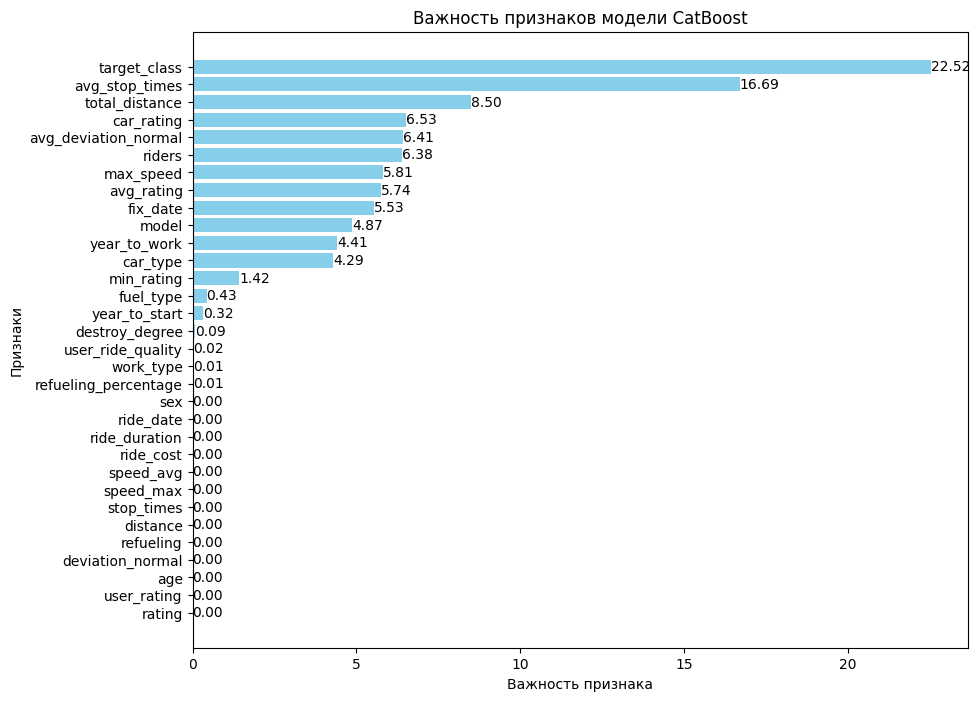

In [14]:
# Сортировка значений важности признаков по убыванию
importance_df_sorted = importance_df.sort_values(by="Importance", ascending=True)

# Создание горизонтальной столбчатой диаграммы
plt.figure(figsize=(10, 8))
bars = plt.barh(importance_df_sorted.index, importance_df_sorted['Importance'], color='skyblue')

# Добавление значений на диаграмме
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2,
             f"{bar.get_width():.2f}", 
             va='center', ha='left')

plt.xlabel('Важность признака')
plt.ylabel('Признаки')
plt.title('Важность признаков модели CatBoost')
plt.show()

### Способ № 2 Phink

In [15]:
# !pip install phik -q

In [16]:
import phik
from phik import resources, report
import seaborn as sns

# Вычисляем корреляцию Phik 
phik_matrix = final_df_cleaned.phik_matrix()

# Отображение корреляционной матрицы Phik
print(phik_matrix)

# Визуализация корреляционной матрицы 
plt.figure(figsize=(12, 10))
sns.heatmap(phik_matrix, annot=True, fmt=".2f", cmap="viridis")
plt.title("Phik Correlation Matrix")
plt.show()

‪![ошибка](1.jpg)
Способ мне не понравился, т.к., на мой взгляд, он пораждает различного рода проблемы, основной из которых является необходимость решить что-то с колонкой `fix_date`. Самым разумным представляется использовать какие-то конкретные данные из нее, например день или время поломки, а не всю дату целиком. Можно еще и дропнуть ее, но в таком случае, мы можем потерять потенциальный признак, который может быть важным для нашего анализа. Чтобы выполнить задание и не терять время, я дропнул эту колонку, но на самом деле, не будь это частью задания и будь у меня больше времени на исследование, я бы так не поступил!

interval columns not set, guessing: ['car_rating', 'year_to_start', 'riders', 'year_to_work', 'target_reg', 'min_rating', 'avg_rating', 'total_distance', 'max_speed', 'avg_stop_times', 'refueling_percentage', 'avg_deviation_normal', 'rating', 'ride_duration', 'ride_cost', 'speed_avg', 'speed_max', 'stop_times', 'distance', 'refueling', 'user_ride_quality', 'deviation_normal', 'age', 'user_rating', 'sex', 'destroy_degree']
                         model  car_type  fuel_type  car_rating  \
model                 1.000000  1.000000   1.000000    0.249718   
car_type              1.000000  1.000000   0.694427    0.090503   
fuel_type             1.000000  0.694427   1.000000    0.073095   
car_rating            0.249718  0.090503   0.073095    1.000000   
year_to_start         0.578220  0.281361   0.025406    0.132854   
riders                0.550906  0.312185   0.057774    0.218532   
year_to_work          0.317306  0.137838   0.054148    0.136937   
target_reg            0.423454  0.2294

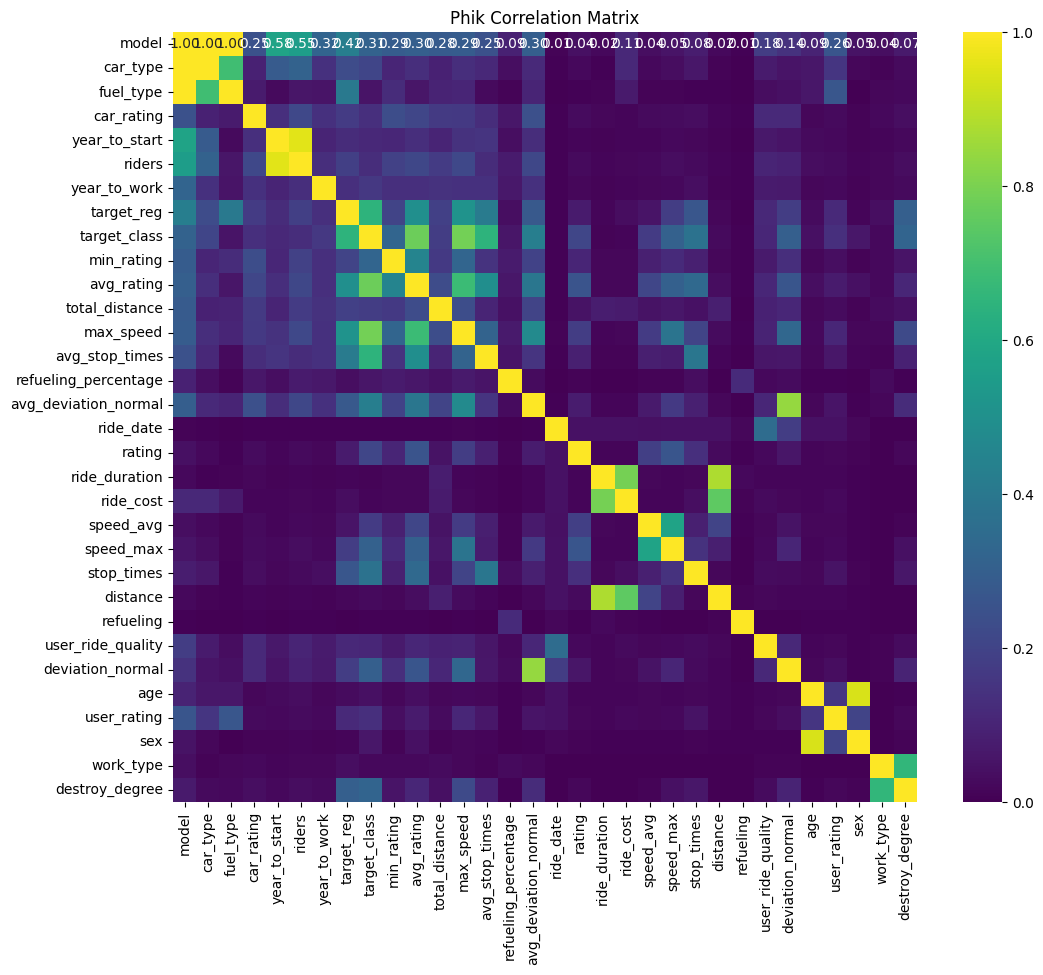

In [17]:
import phik
from phik import resources, report
import seaborn as sns

# Дропаю 'fix_date'
final_df_drop = final_df_cleaned.drop(columns=['fix_date'])

# Вычисляем корреляцию Phik 
phik_matrix = final_df_drop.phik_matrix()

# Отображение корреляционной матрицы Phik
print(phik_matrix)

# Визуализация корреляционной матрицы 
plt.figure(figsize=(12, 10))
sns.heatmap(phik_matrix, annot=True, fmt=".2f", cmap="viridis")
plt.title("Phik Correlation Matrix")
plt.show()

### Способ № 3 Shap

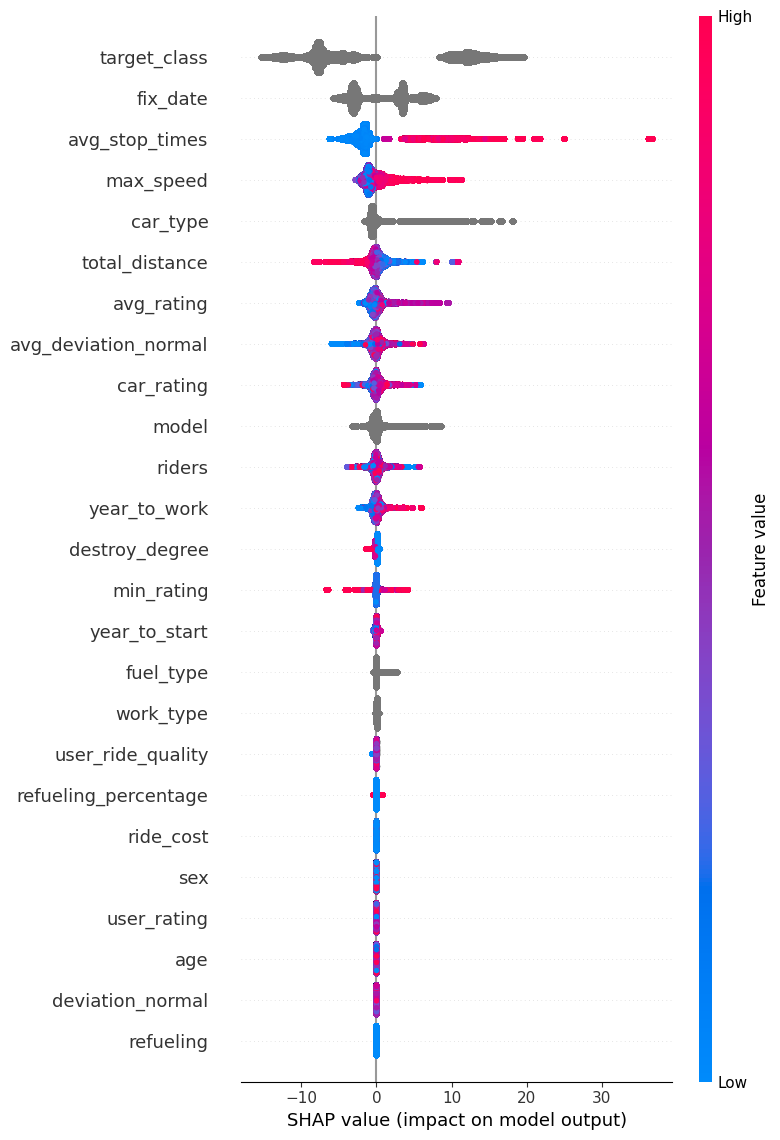

In [18]:
import shap
# Создание объекта TreeExplainer 
explainer = shap.TreeExplainer(model)

# Вычисление SHAP values
shap_values = explainer.shap_values(pool_test)

# Визуализация средней абсолютной величины значений SHAP для каждого признака
shap.summary_plot(shap_values, X_test, max_display=25)

**Вывод**: На мой взгляд, лучше всего показал себя метод с Catboost feature importance. Он более прост в использовании, не нужна и устойчив к различному типу данных. Также более наглядный и показательный, по моему мнению. 

# Домашнее задание 2. Прогноз времени и вида поломки машин. Настройка ML-модели

<div class="alert alert-info">

**Цель блока** — составить тренировочную и валидационную выборки, произвести обучение модели `CatBoostClassifier` на тренировочной части и оценить качество на валидационной.

##Обучение первой модели (5 баллов)

1.   Новый пункт
2.   Новый пункт



1. Классифицируйте признаки на типы (категориальные, числовые, таргеты).

2. Выделите в `X` только признаки, а в `Y` — таргет (для задачи классификации).

3. Сделайте разделение данных на *обучающую* и *валидационную* выборки (не забывайте про воспроизводимость результатов).

4. Создайте и обучите `CatBoostClassifier` модель (настраивать гиперпараметры сейчас не обязательно).

5. Проведите оценку вашей модели, используя метрику `accuracy`.


<h4> Критерии оценивания </h4>
    
- По 1 баллу за каждый корректно выполненный пункт.

</div>

In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
features2drop = [...] # то, что надо выбросить
targets = [...] # таргеты
cat_features = [...] # категориальные признаки

num_features = [...] # числовые признаки

print('Категориальные признаки:', len(cat_features), cat_features)
print('Числовые признаки:', len(num_features), num_features)
print('Целевые переменные', targets)

In [ ]:
# YOUR CODE HERE

# Дополнительное задание. Визуализация прогнозов, ошибок модели и важности признаков

<div class="alert alert-info">

**Цель блока** — визуализировать результаты прогнозирования, ошибки модели и важность признаков для лучшего понимания и анализа модели.

## Визуализация (5 баллов)

   
1. Визуализируйте важность признаков встроенным методом в `CatBoost`  (помните, что не стоит сильно доверять этому рейтингу важности, т. к. для сильно скоррелированных признаков важность делится пополам — оба признака могут улететь вниз).

2. Постройте `waterfall_plot` из библиотеки `SHAP` (подробнее во втором ноутбуке из полезных ссылок ниже).
    
3. Постройте `classification_report` из библиотеки `scikit-learn`.

4. Постройте и визуализируйте матрицу смежности (`confusion_matrix`), посмотрите, в каких классах модель больше всего ошибается.
    
5. Для каждого графика/примененного метода проинтерпретируйте результаты и сделайте выводы.


<h4> Критерии оценивания </h4>
    
- По 1 баллу за каждый корректно выполненный пункт.
    
</div>

<div class="alert alert-success">

Визуализация может помочь даже после того, как мы **уже обучили** какую-нибудь модель. Например:

- Понять, что мешает модели или чего не хватает, чтобы не допускать ошибки.
- Сделать выводы, как можно улучшить точность в последующих экспериментах.
- Визуализировать ошибки модели.
- Отсеять лишние признаки.
- Найти идеи для новых признаков.
- Все зависит от типа ваших данных.

<h3> Полезные источники </h3>
    
- Занятие про визуализацию и Seaborn.
- Занятие про продвинутую визуализацию и анализ ошибок модели.

</div>    

In [ ]:
# YOUR CODE HERE

# Домашнее задание 3. Оптимизация. Тюнинг гиперпараметров с помощью `Optuna`

<div class="alert alert-info">

**Цель блока** — улучшить качество предсказания, произведя подбор гиперпараметров для модели с помощью `Optuna`.

## Подбор гиперпараметров (3 балла)

1. Напишите `objective` функцию и запустите `Optuna`.
2. Подберите гиперпараметры для `CatBoostClassifier` (минимум 3).
3. Обучите модель с новыми гиперпараметрами, сравните качество и сделайте выводы.

    
<h4> Критерии оценивания </h4>
    
- 1 балл за каждый корректно выполненный пункт.
    
</div>

In [ ]:
# YOUR CODE HERE

### Общая информация по `Optuna`

#### Ключевые особенности <code>Optuna</code>



- Легковесность и универсальность — можно подбирать оптимальные параметры под любые функции и метрики.
- SOTA-алгоритмы, адаптированные для поиска гиперпараметров.
- Параллелизация и различные методы прунинга.
- Встроенная визуализация.
- Интеграция со множеством популярных библиотек (бустинги, sklearn, PyTorch, W&B и другие).

Разберем Optuna по частям, чтобы понять, как ее использовать.

#### <code>Study</code>: оптимизация, базирующаяся на <code>Objective</code> функции



В `Objective`-функцию нужно написать код подсчета метрики, которую возвращаем. `Objective` вызывается Optuna много раз для подбора лучших параметров.
```python
def objective(trial, ...):
    # calculate score...
    return score
```

<h4> <code>Trial</code> — одно выполнение <code>Objective</code>-функции</h4>

В `trial`-объекте мы передаем параметры для «перебора», используя для каждого типа свой метод. Например:

```python
# метод `suggest_float` показывает, что перебираем `float` значения, от 0 и до 1.5 границы
param = trial.suggest_float('param', 0, 1.5)

# Категориальное значение
loss_function = trial.suggest_categorical('loss', ['Logloss', 'CrossEntropy'])

# Целочисленное значение
depth = trial.suggest_int('depth', 5, 8)

# Равномерное распределение
learning_rate = trial.suggest_uniform('learning_rate', 0.0, 1.0)
```

#### `Study` parameters

Инициализируем объект `study`, который начнет перебор и сохранит в себе историю результатов.
Если мы стараемся увеличить метрику, а не уменьшить ошибку, то используем `create_study(direction='maximize')`.
```python
study = optuna.create_study()
study.optimize(objective, n_trials=10)
```

<div class="alert alert-info">
    
В [`Optuna`](https://optuna.readthedocs.io/en/stable/index.html) реализовано несколько методов (`sampler`) подбора параметров (в том числе классические):
* `GridSampler`
* `RandomSampler`
* `Tree-Structed Parzen Estimator` (`TPESampler` — самый популярный, дефолтный)
* `BruteForceSampler`
* [Другие 4 метода](https://optuna.readthedocs.io/en/stable/reference/samplers/index.html#module-optuna.samplers) (можно написать собственный семплер)

### Советы по перебору параметров

- Иметь понимание важности параметров.
- Число `iterations` лучше взять с запасом и зафиксировать, при этом ограничив через `early_stopping_rounds`.
- Подсмотреть или чувствовать диапазоны и шаг значений.
- Исключить то, что перебирать не нужно (`random_seed` , `eval_metric`, `thread_count` и прочее).
- Используйте информацию с прошлых попыток.

# Домашнее задание 4. Блендинг

<div class="alert alert-info">

**Цель блока** — улучшить качество предсказания, объединив несколько моделей вместе методом блендинга.

## Задание 6. Блендинг (10 баллов)

1. Построить и обучить модели:
    - `CatBoostClassifier`,
    - `LightGBMClassifier (goss)`,
    - `XGBoostClassifier (dart)`,
    - `RandomForestClassifier`.
2. Сделать предсказания каждой моделью, оценить качество.
3. Реализовать блендинг двумя способами, оценить качество и сравнить с предыдущим пунктом:
    - `Hard Voting` —  метод, при котором делаем голосование всех моделей и выбираем самый популярный класс.
    - `Soft Voting` —  метод, при котором мы складываем вероятности предсказания всех моделей по каждому классу и потом выбираем самый класс с максимальной суммой.
    
<h4> Критерии оценивания </h4>
    
- Обучены 4 модели — 1 балл за каждую обученную модель, всего 4 балла.
- Для модели проведен подбор гиперпараметров — 0,5 балла за каждый параметр, всего 2 балла.
- Сделаны предсказания каждой модели и оценено качество — 1 балл.
- Реализован `Hard Voting` — 1 балл.
- Реализован `Soft Voting` — 1 балл.
- Сделаны выводы — 1 балл.
    
</div>

In [ ]:
# YOUR CODE HERE

### Общая информация о блендинге

**Основная идея** — взять от каждого алгоритма лучшее и совместить несколько разных ML-моделей в одну.

Что это дает:
- Увеличивается обобщающая способность финальной модели и качество улучшается.
- Модель становится более стабильной, что позволяет не слететь на приватном лидерборде.

Особенно хорошо накидывает блендинг, если смешиваемые модели имеют разную природу — например, нейронные сети, kNN и решающие деревья. Они выучивают разные зависимости и хорошо дополняют друг друга.

</div>

# <center id="part6"> Отправка финального решения на лидерборд на Kaggle

<div class="alert alert-info">

**Цель блока** — сделать предсказание с помощью блендинга для тестовой части датасета, отправить результат [в соревнование на Kaggle](https://www.kaggle.com/competitions/competative-data-science-course-by-data-feeling/overview).

## Задание 8. Предсказание на тестовом датасете и отправка на Kaggle

1. Сделать предобработку для тестового датасета, присоединить к нему информацию из других датасетов и добавить признаки, которые генерировали для тренировочного датасета.
2. Сделать предсказания каждой моделью, которую хотите включить в ансамбль, но минимум их должно быть 3.
3. Сделать блендинг с помощью `Hard Voting` или `Soft Voting` на ваш выбор.
4. Сохранить результат предсказания в `csv` файл и отправить решение на Kaggle.
    
<h4> Критерии оценивания </h4>
    
- 0 баллов за задание, если итоговый скор на лидерборде меньше чем `0.9`.
- 1 балл за каждый выполненный пункт.

</div>

In [ ]:
car_test = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/car_test.csv')
car_test.head(3)

In [ ]:
# YOUR CODE HERE

### Советы по отправке кода на Kaggle



Если пишете код на `Kaggle`, то для отправки решения:

1. Нажать Save Version.
2. Проверить, что в Advanced Settings выбрано «Всегда сохранять результаты ноутбука».
3. Выбрать тип сохранения Save & Run All (Commit).
4. Нажать кнопку Save.